# Práctica Deep Learning (Alvar Garcia)

El presente proyecto tiene como objetivo principal desarrollar e implementar
un modelo avanzado de Deep Learning que permita predecir con precisión el
nivel de engagement que generarán distintos puntos de interés (POIs) turísticos. Este modelo integrará de manera innovadora dos fuentes de información
complementarias: características visuales extraídas de imágenes y metadatos
estructurados asociados a cada POI.
Los datos utilizados en este estudio provienen de la plataforma Artgonuts, garantizando así su relevancia y aplicabilidad en contextos reales
del sector turístico. Las imágenes empleadas han sido específicamente procesadas para los fines de esta práctica, siendo sus versiones originales en alta
resolución procedentes de diversas fuentes, incluyendo el portal de datos
abiertos de la Comunidad de Madrid.
El desafío central consiste en desarrollar un sistema capaz de anticipar
con exactitud el nivel de interacción que cada POI generará, basándose tanto
en sus atributos visuales como en sus metadatos descriptivos.

Con esta predicción, se pretende:

- Optimizar la seleccion y priorización de contenido para maximizar la interacción del usuario.

- Identificar patrones visuales y características que correlacionan con
mayor engagement

- Mejorar la experiencia del usuario al destacar contenido más relevante
y atractivo

- Proporcionar insights data-driven para la toma de decisiones sobre
nuevos POIs


# 1. Carga de los datos y de paquetes:

En la práctica se va a usar PyTorch para crear el modelo de red neuronal para predecir el nivel de engagement de los diferentes puntos de interés turístico.

Para la carga de datasets, primero se crea una carpeta en Drive que contenga el paquete "module_utils", "poi_dataset.csv" y la carpeta que contiene el dataset de imagenes a usar, "data_main". Se llama a esta carpeta "practicas_DL". Desde aqui se extraeran los archivos a usar durante la práctica.



## 1.1. Carga de paquetes:

In [3]:
import sys

# Montamos el drive para tener el directorio donde se encuentran los archivos dispoble
from google.colab import drive
drive.mount('/content/drive')

# Se configura el path de python para acceder module_utils que está contenido en esta
# carpeta
sys.path.append("/content/drive/MyDrive/practicas_DL")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torchvision import datasets, transforms
# from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from module_utils import *
import os
# from IPython.testing import test
from itertools import chain
import ast
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## 1.2. Carga de datos:

### 1.2.1. Carga del csv "poi_dataset"

In [5]:
# En primer lugar, se debe cargar el archivo csv y convertirlo en un dataframe

poi_df = pd.read_csv("/content/drive/MyDrive/practicas_DL/poi_dataset.csv")

In [6]:
# Se verifica la carga del dataset con una primera visualización de su 'shape'

poi_df.shape


(1569, 14)

### 1.2.2. Carga del dataset de imagenes "data_main"

In [7]:


# Se carga el dataset completo
IMAGE_ROOT = "/content/drive/MyDrive/practicas_DL/data_main"


image_paths = []

for root, _, files in os.walk(IMAGE_ROOT):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, f))

image_paths = sorted(image_paths)

# Se extrae el nombre del archivo para que coincida con la columna "ID"
#  del POI CSV
image_ids = [
    os.path.basename(os.path.dirname(p))
    for p in image_paths
]

# Se define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. Preparación y análisis  de los datos:

## 2.1. Análisis exploratorio del dataset:

Para el preprocesamiento de datos, es necesario primero visualizar los datos para conocer su naturaleza.

Se comienza con las imágenes. Se crea una función para visualizar las imagenes junto con sus ids.

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images_with_ids_from_paths(image_paths, n=6):
# Se usa para visualizar n imagenes junto con sus ids.
    paths = image_paths[:n]

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    for ax, path in zip(axes, paths):
        img = Image.open(path).convert("RGB")
        img_id = os.path.basename(os.path.dirname(path))

        ax.imshow(img)
        ax.set_title(img_id, fontsize=9)
        ax.axis("off")

    plt.show()

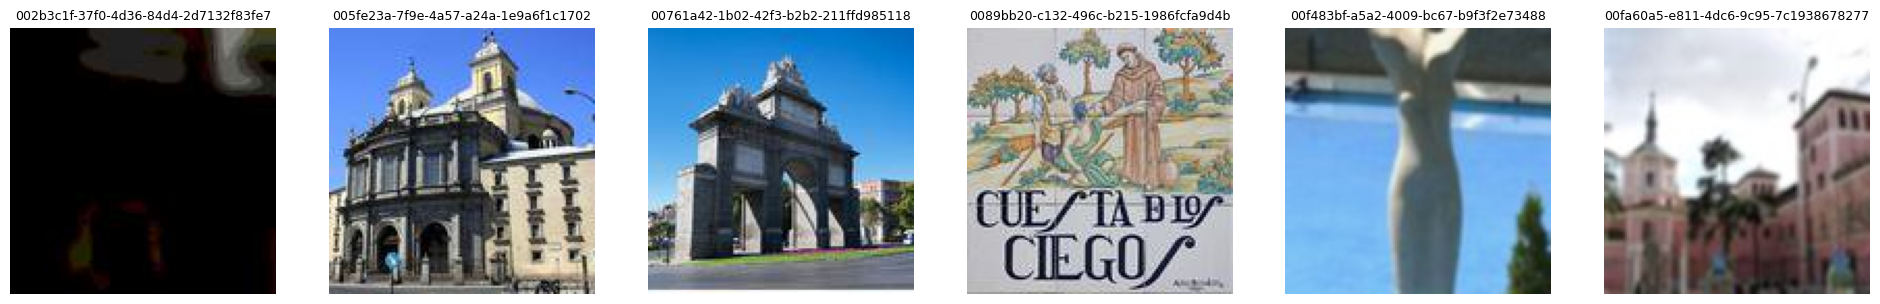

In [9]:
show_images_with_ids_from_paths(image_paths, n=6)

In [10]:
num_images = len(image_paths)
print("Number of images:", num_images)

Number of images: 1492


- Como podemos observar, las imágenes son de distintas calidades.
- Podemos ver que hay 1492 imágenes en el dataset. Se observó anteriormente que las dimensiones dep dataset de POIs era mas largo (1569 filas). Se estudiará como tratar este hecho.

A continuación, se exploran los datos del poi_csv:

In [11]:
poi_df.head()

,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


In [12]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


In [13]:
poi_df.describe()

,tier,locationLon,locationLat,xps,Visits,Likes,Dislikes,Bookmarks
count,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,1.541109,-1.132337,39.900141,750.382409,10011.943276,3623.908222,2526.305927,973.261950
std,0.637677,22.733401,9.662134,228.319854,5.456808,4817.879374,2225.543360,1453.333948
min,1.000000,-121.951049,-62.940930,0.000000,10001.000000,100.000000,52.000000,50.000000
25%,1.000000,-3.725292,40.411754,600.000000,10008.000000,464.000000,937.000000,116.000000
50%,1.000000,-3.699140,40.421738,700.000000,10011.000000,1434.000000,2718.000000,306.000000
75%,2.000000,-3.673348,40.472458,1000.000000,10015.000000,6840.000000,3399.000000,1309.000000
max,4.000000,158.333118,65.706572,1000.000000,10038.000000,26425.000000,10999.000000,8157.000000


A primera vista, parece que no hay valores null, aunque se explorará más el dataset para asegurar que no hay valores faltantes más adelante.
- A continuación, se visualizarán los conteos de valores de las distintas columnas para discernir si hay filas sobrantes, o filas duplicadas.

In [14]:
# Se crea un bucle para visualizar los valores con mas frecuencias dentro de
# cada columna, donde donde el tipo de dato en la columna es 'int64' o 'float64'
for col in poi_df.select_dtypes(include=("int64", "float64")):
    print(poi_df[col].value_counts(dropna=False).head(30))
    print("\n")

tier
1    837
2    622
3    103
4      7
Name: count, dtype: int64


locationLon
 0.074308      7
-3.681532      7
 21.484256     6
 21.159632     6
 13.160577     6
-0.090630      6
-3.762097      6
-9.395970      5
 127.693849    5
-0.147064      5
 15.288208     5
 21.630590     5
-3.901605      4
 134.018389    4
-6.590018      4
 1.389906      4
 135.803626    4
-3.712677      4
 0.887937      4
-3.898331      4
-3.761360      4
-3.689442      3
-7.868750      3
-3.664691      3
-3.690752      3
-7.908311      3
 0.070131      3
-58.385910     3
-3.675759      3
-58.394205     3
Name: count, dtype: int64


locationLat
 51.682622    7
 40.421193    7
 40.448713    6
 54.042053    6
 51.512306    6
 50.016484    6
 49.654616    6
 26.227314    5
 39.721704    5
 49.961723    5
 51.566995    5
 38.796383    5
 51.387777    4
 40.442985    4
 52.224758    4
 57.761888    4
 40.411760    4
 34.465609    4
 57.448512    4
 33.855356    4
 50.580627    4
 40.434913    3
 43.768778    3
 

In [15]:
# Se crea un bucle para visualizar los valores con mas frecuencias dentro de
# cada columna, donde el tipo de dato en la columna es 'object'
for col in poi_df.select_dtypes(include="object"):
    print(poi_df[col].value_counts(dropna=False).head(30))
    print("\n")

id
a0f3f39c-fc87-4031-900d-d4776b1f3491    7
61a339d8-d9d6-4abc-9425-455d062e3338    6
060c7567-ef4a-4f09-9607-a4e3c2d4ad5c    6
5b38dcaa-19ac-422d-9c74-5b29e2a19629    6
fde6f250-9196-4ca8-8351-a9e8b15a63b6    6
ffd48a7d-f1f7-425c-9c52-fa534cc82167    5
3f17de6e-21e7-4d3a-b4ec-29c0630aebb4    5
48057ac3-5306-422f-95fa-0ff0937124bb    5
8313dc99-1dd6-4994-976a-505650fb5c7e    5
9d06c579-b645-41ce-b2f4-b57524cc7cea    5
bf345996-7402-47ac-abaa-cbfb19eefb0b    4
fb41c189-6d0a-488b-8c82-95dad97567f7    4
1728c4c3-7655-497c-b4ef-76d430ee2044    4
04be145b-f73e-41aa-9332-d1702684dc53    4
8083365a-4ad8-45a2-b08a-e7ea63bf1db0    4
23869080-e075-47f0-bb14-a07f6c704995    4
af0f8a7b-ca71-469e-a882-f20705acf206    4
31057c38-af33-46cc-95b1-341c037fec50    3
7f6e10d2-ff8d-447a-8f40-28d3c5c4c771    3
651efcc9-29a8-4781-bf73-10dfa65a7d69    3
f67f254e-da95-40ef-820c-602a2d09e979    3
d5c11570-41c3-40d2-bc1a-b3217780cd2c    2
e5427b0f-dd8c-4a31-bbe2-9c31a654a464    2
49b9c79c-9cef-4590-909f-c478ef2

Como se puede observar, en la columna 'tags' existe 107 valores vacíos. Se entiende que estos valores no son faltantes, si no que es un valor válido 'vacío', que tiene un significado en sí. También se observan un número de valores repetidos en las columnas de name y id, lo que lleva a la conclusión de que hay filas en el dataset que hacen alusion a una misma imagen. Se creara un diccionario de aggregations para unificar estas filas.



## 2.2. Preprocesamiento de datos:

### 2.2.1. Imágenes:

- En principio, no se tratan más las imágenes de momento.

### 2.2.2. Tratamiento valores faltantes:



- Como se ha visto antes, no se encuentran valores faltantes, con lo que no es necesario tratar los mismos.

### 2.2.3. Tratamiento de valores de poi_csv:

- Como hemos podido ver en el punto anterior, no se observan valores faltantes en ninguna columna de las observadas.

- Lo que si que se ha observado es que hay filas duplicadas. Estas filas se van a unificar en una sola, y para esto se va a usar un diccionario de aggs para llevar a cabo transformaciones en distintas columnas. Para los likes, dislikes, bookmarks y visitas, vamos a llevar a cabo una suma. Para otras columnas como el nombre o la latitud, se mantendrá el primer valor encontrado. Por último, los tags y categorias serán sumadas usando una función merge_unique_lists, que creará una lista de valores unicos encontrados entre los duplicados.

In [16]:
# Se crea una función para sumar las entradas de los tags pero que solo se
# listen los valores únicos.

def merge_unique_lists(series):
    # La suma de tags generará una lista con solo valores unicos
    items = []

    for sub in series:
        if pd.isna(sub):
            continue
        elif isinstance(sub, list):
            items.extend(sub)
        else:
            items.append(sub)

    return list(dict.fromkeys(items))

agg_funcs = {
    "Visits": "sum",      # se suman los valores de las columnas
    "Likes": "sum",
    "Dislikes": "sum",
    "Bookmarks": "sum",
    "categories": merge_unique_lists,
    "tags": merge_unique_lists,
    "name": "first",  # se fija el primer valor como valido
    "shortDescription": "first",
    "tier": "first",
    "locationLon": "first",
    "locationLat": "first",
    "xps": "first",
    "main_image_path": "first"

}

poi_df_final = poi_df.groupby("id", as_index=False).agg(agg_funcs)

Por último, se ordenan las columnas con listas ('categories' y 'tags') para que sus conteos de valores sean menos heterogeneas

In [17]:
poi_df_final["categories"] = poi_df["categories"].apply(
    lambda x: sorted(x) if isinstance(x, list) else x
)
poi_df_final["tags"] = poi_df["tags"].apply(
    lambda x: sorted(x) if isinstance(x, list) else x
)

In [18]:
# Se convierte la columna de string a list
poi_df_final["categories"] = poi_df_final["categories"].apply(ast.literal_eval)
poi_df_final["tags"] = poi_df_final["tags"].apply(ast.literal_eval)


In [19]:
poi_df_final.head()

,id,Visits,Likes,Dislikes,Bookmarks,categories,tags,name,shortDescription,tier,locationLon,locationLat,xps,main_image_path
0,002b3c1f-37f0-4d36-84d4-2d7132f83fe7,10010,865,3099,118,"[Escultura, Pintura]",[],Casa-Museo de la Inquisición de Garganta la Olla,¡Visita la Casa-Museo de la Inquisición! Un vi...,1,-5.776669,40.111279,1000,data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7...
1,005fe23a-7f9e-4a57-a24a-1e9a6f1c1702,10011,8384,136,2275,"[Patrimonio, Historia]",[],Real Basílica de San Francisco el Grande,"La Real Basílica de San Francisco el Grande, j...",2,-3.714472,40.410457,250,data_main/005fe23a-7f9e-4a57-a24a-1e9a6f1c1702...
2,00761a42-1b02-42f3-b2b2-211ffd985118,10006,8359,146,2151,"[Ciencia, Patrimonio]",[],Puerta de Toledo,¡Visita la Puerta de Toledo! Un arco triunfal ...,1,-3.711620,40.406714,800,data_main/00761a42-1b02-42f3-b2b2-211ffd985118...
3,0089bb20-c132-496c-b215-1986fcfa9d4b,10007,8398,137,2487,[Cultura],[],Cuesta de los ciegos,La Cuesta de los Ciegos es una escalera empedr...,3,-3.714567,40.412984,150,data_main/0089bb20-c132-496c-b215-1986fcfa9d4b...
4,00f483bf-a5a2-4009-bc67-b9f3f2e73488,10010,353,3901,82,"[Patrimonio, Cultura]",[],Escultura de AENA,"Admira la Escultura AENA, un símbolo de modern...",2,-3.652625,40.450756,600,data_main/00f483bf-a5a2-4009-bc67-b9f3f2e73488...


Hay algunas variables que vamos a eliminar, ya que no van a dar información importante para el entrenamiento de la red neuronal. Estas columnas van a ser:

- name
- shortDescription

Las guardaremos en un dataset llamado dropped_variables por si hay que recuperarlas en algun momento.


In [20]:
dropped_variables = poi_df_final[["name", "shortDescription"]]
poi_df_final = poi_df_final.drop(["name", "shortDescription"], axis = 1)

A continuación veremos como tratar la variable 'tags':

In [21]:
poi_df_final['tags'].value_counts()

,count
tags,
[],107
[Abandonados],6
[Yacimientos],5
[Paranormal],4
"[tapas, castizo]",4
...,...
"[Salamanca, Arte, España, Estatua, Recoletos, Tradición escultórica, Historia, Cultura, Escultura, Alfonso x el sabio, Mármol, Patrimonio, Biblioteca nacional]",1
"[Esparcimiento, Madrid, Arte, Jardín artístico, Salamanca, Refugio, Historia, Cultura, Escultura conceptual o abstracta, Naturaleza, Esculturas, Fuente del berro, Contemporáneo]",1
"[Tolerancia, Madrid, Arte, Distrito, Historia, Escultura conceptual o abstracta, Memoria, Diversidad cultural, Escultura, Paz, Holocausto, Reflexión]",1


Esta variable tiene un gran numero de tags vacios y un gran numero de tags distintos, y por tanto creo que más que los tags en si, una forma de extraer información de esta variable sería fijarse en el número de tags presentes en cada entrada.

In [22]:
poi_df_final["num_tags"] = poi_df_final["tags"].apply(len)

In [23]:
poi_df_final["num_tags"].value_counts()

,count
num_tags,
10,473
13,465
0,107
1,100
4,89
12,88
5,51
3,46
6,30


Con esto, nos quedaría tratar las variables de longitud y latitud.

In [24]:
poi_df_final[["locationLon","locationLat"]].value_counts()

,,count
locationLon,locationLat,
-3.681532,40.421193,7
-3.762097,40.448713,6
-3.761360,40.411760,4
-3.712677,40.442985,4
-3.664691,40.430233,3
...,...,...
-3.711694,40.470466,1
-3.711735,40.418776,1
-3.711819,40.420001,1


Estas dos variables serán normalizadas más adelante.

### 2.2.3. Codificación de variables categóricas:

Para discernir como tratar las variables categóricas, se comenzará por visualizar los datos de cada una de ellas. Las columnas categoricas dentro de nuestro dataset son:

- categories
- tier




In [25]:
poi_df_final['categories'].value_counts()

,count
categories,
"[Patrimonio, Historia, Arquitectura]",99
"[Patrimonio, Arquitectura, Historia]",84
"[Historia, Cultura, Escultura]",76
"[Cultura, Escultura, Historia]",66
"[Cultura, Arquitectura, Historia]",64
...,...
"[Cine, Patrimonio, Historia, Misterio]",1
"[Ocio, Arquitectura, Historia, Misterio]",1
"[Historia, Arquitectura, Patrimonio, Misterio]",1


Para tratar esta variable, definiremos una lista de todas las palabras que entran dentro de las 'categorias'

In [26]:
# Se crea una lista con todas las categorias dentro de la variable 'categories'
all_categories = sorted(set(chain.from_iterable(poi_df_final["categories"])))
categories_to_idx = {cat: i for i, cat in enumerate(all_categories)}
num_categories = len(categories_to_idx)

In [27]:
categories_to_idx

{'Arquitectura': 0,
 'Ciencia': 1,
 'Cine': 2,
 'Cultura': 3,
 'Escultura': 4,
 'Gastronomía': 5,
 'Historia': 6,
 'Misterio': 7,
 'Naturaleza': 8,
 'Ocio': 9,
 'Patrimonio': 10,
 'Pintura': 11}

Ahora se crean indices para cada elemento de la columna

In [28]:
# Se define una función de creacion de los tensores de categoría
def encode_category_indices(categories, categories_to_idx):
    return torch.tensor(
        [categories_to_idx[c] for c in categories],
        dtype=torch.long
    )

poi_df_final["categories_idx"] = poi_df_final["categories"].apply(
    lambda x: encode_category_indices(x, categories_to_idx)
)

In [29]:
poi_df_final["categories_idx"] .head(40)

,categories_idx
0,"[tensor(4), tensor(11)]"
1,"[tensor(10), tensor(6)]"
2,"[tensor(1), tensor(10)]"
3,[tensor(3)]
4,"[tensor(10), tensor(3)]"
5,"[tensor(6), tensor(3)]"
6,"[tensor(6), tensor(0)]"
7,[tensor(6)]
8,"[tensor(0), tensor(6)]"
9,"[tensor(0), tensor(10)]"


In [30]:
# Se crea una 'embedding bag' para devolver indices en vex de vectores
def encode_category_indices(categories, categories_to_idx):
    return torch.tensor(
        [categories_to_idx[c] for c in categories],
        dtype=torch.long
    )

poi_df_final["categories_idx"] = poi_df_final["categories"].apply(
    lambda x: encode_category_indices(x, categories_to_idx)
)

In [31]:
# Se crea el Embedder a traves de una clase
class CategoryEmbedding(nn.Module):
    def __init__(self, num_categories, embedding_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(
            num_embeddings=num_categories,
            embedding_dim=embedding_dim,
            mode="mean"  # or "sum"
        )

    def forward(self, category_indices, offsets):
        return self.embedding(category_indices, offsets)

In [32]:
# Se define una funcion para que la lista que viaja al split sea de ints y
# no de tensores (ya que seguimos operando en pandas)
def tensor_list_to_int_list(x):
    return [int(t.item()) for t in x]

poi_df_final['categories_idx'] = (
    poi_df_final['categories_idx']
    .apply(tensor_list_to_int_list)
)

In [33]:
type(poi_df_final['categories_idx'].iloc[0][0])
# debe ser <class 'int'>

int

Finalmente, se pasa a tratar la columna 'tiers':

In [34]:
poi_df_final['tier'].value_counts()

,count
tier,
1,765
2,617
3,103
4,7


In [35]:
# Exploración inicial - no afecta entrenamiento
# tier_4 = poi_df_final[poi_df_final['tier'] == 4]
# tier_4.head()

In [36]:
# Exploración inicial - no afecta entrenamiento
# tier_1 = poi_df_final[poi_df_final['tier'] == 1]
# tier_1.head()

Tras esta breve exploración de los POIs contenidos dentro del tier 4 y el tier 1, y según la explicacion de los metadatos del pleigo de las prácticas, se entiende que el Tier 1 es el de localizaciones de mayor importancia y el tier 4 el de menor.
- Debido a la naturaleza de esta variable, se aplicará OrdinalEncoder:
- Como 0 tambíen es un valor a tener en cuenta, convertiremos los tiers a 0,1,2 y 3.

In [37]:
poi_df_final['tier_encoded'] = poi_df_final['tier'] - 1

In [38]:
# Nos aseguramos de que no hay otros valores presentes en esta variable
expected_values = {0, 1, 2, 3}
actual_values = set(poi_df_final["tier_encoded"].dropna().unique())

assert actual_values.issubset(expected_values), \
    f"Unexpected tier values found: {actual_values - expected_values}"

In [39]:
# 0 > 1 > 2 > 3  →  Como el valor 0 es el mas importante, se invierten los valores de la variable
poi_df_final["tier_ord"] = (3 - poi_df_final["tier_encoded"]) / 3.0

In [40]:
poi_df_final["tier_ord"].value_counts()

,count
tier_ord,
1.000000,765
0.666667,617
0.333333,103
0.000000,7


In [41]:
# Sanity check:
assert poi_df_final["tier_ord"].between(0, 1).all()

In [42]:
poi_df_final.head()

,id,Visits,Likes,Dislikes,Bookmarks,categories,tags,tier,locationLon,locationLat,xps,main_image_path,num_tags,categories_idx,tier_encoded,tier_ord
0,002b3c1f-37f0-4d36-84d4-2d7132f83fe7,10010,865,3099,118,"[Escultura, Pintura]",[],1,-5.776669,40.111279,1000,data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7...,0,"[4, 11]",0,1.000000
1,005fe23a-7f9e-4a57-a24a-1e9a6f1c1702,10011,8384,136,2275,"[Patrimonio, Historia]",[],2,-3.714472,40.410457,250,data_main/005fe23a-7f9e-4a57-a24a-1e9a6f1c1702...,0,"[10, 6]",1,0.666667
2,00761a42-1b02-42f3-b2b2-211ffd985118,10006,8359,146,2151,"[Ciencia, Patrimonio]",[],1,-3.711620,40.406714,800,data_main/00761a42-1b02-42f3-b2b2-211ffd985118...,0,"[1, 10]",0,1.000000
3,0089bb20-c132-496c-b215-1986fcfa9d4b,10007,8398,137,2487,[Cultura],[],3,-3.714567,40.412984,150,data_main/0089bb20-c132-496c-b215-1986fcfa9d4b...,0,[3],2,0.333333
4,00f483bf-a5a2-4009-bc67-b9f3f2e73488,10010,353,3901,82,"[Patrimonio, Cultura]",[],2,-3.652625,40.450756,600,data_main/00f483bf-a5a2-4009-bc67-b9f3f2e73488...,0,"[10, 3]",1,0.666667


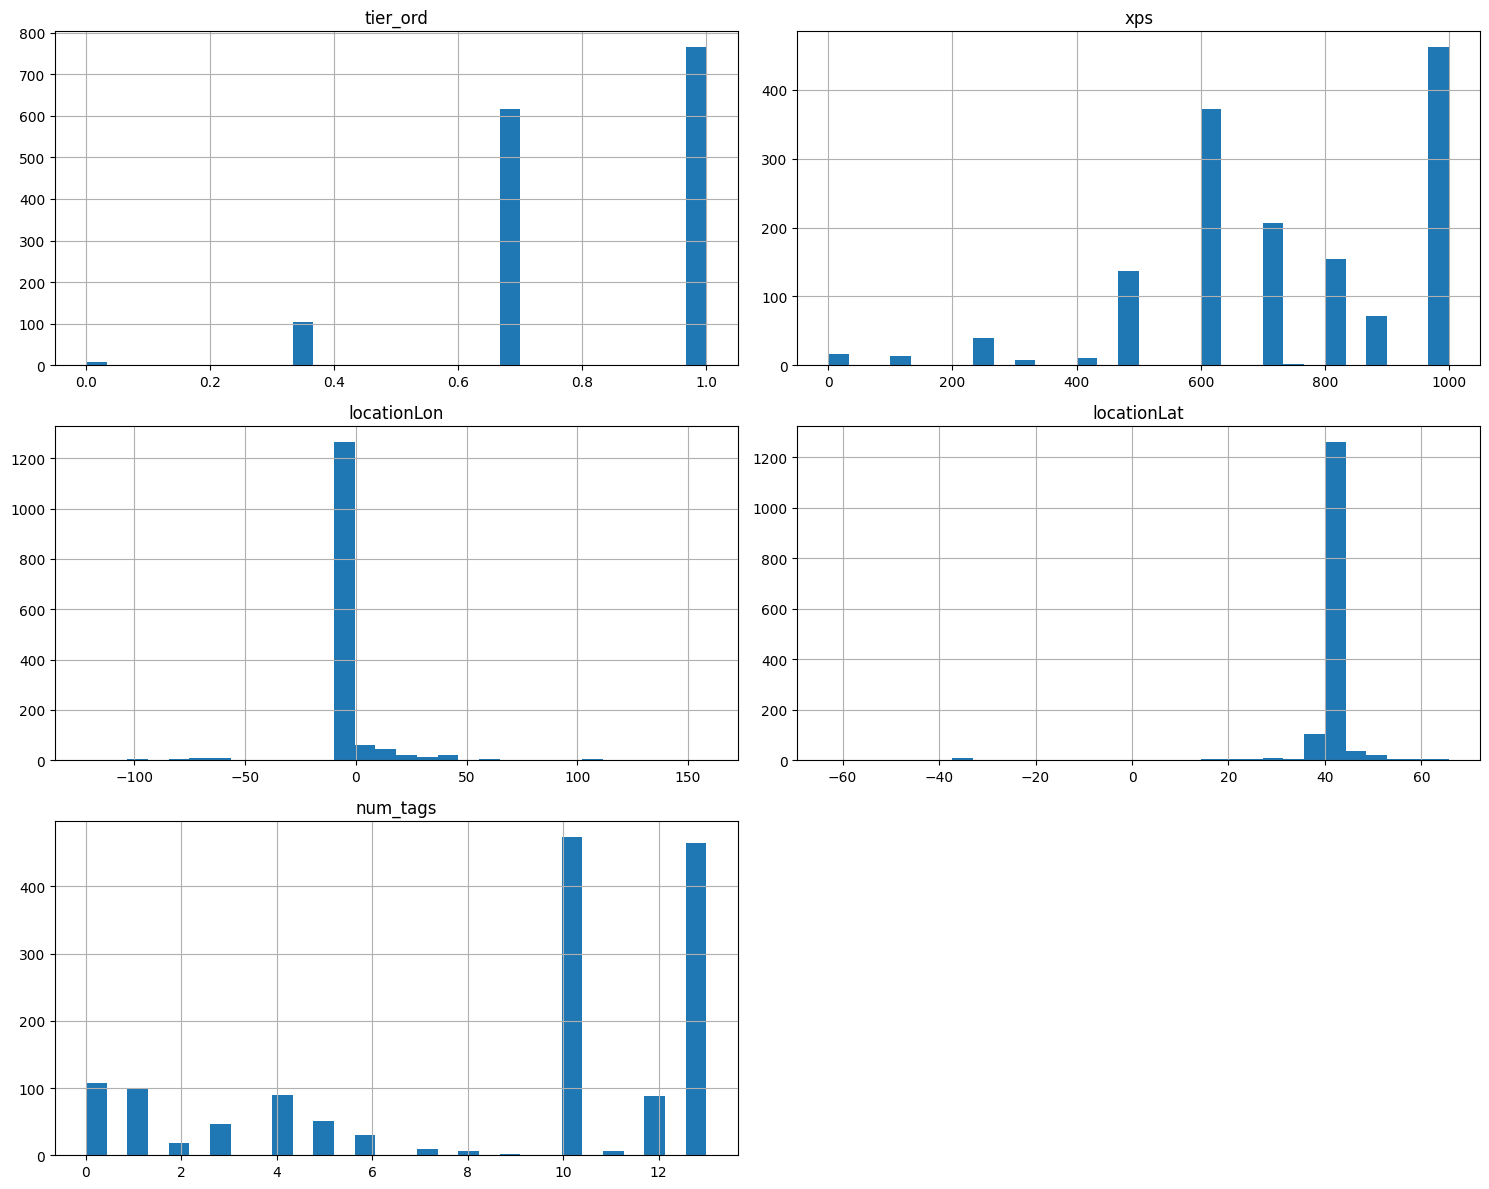

In [43]:
poi_df_final[['tier_ord','xps','locationLon','locationLat','num_tags']].select_dtypes(include=[np.number]).hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

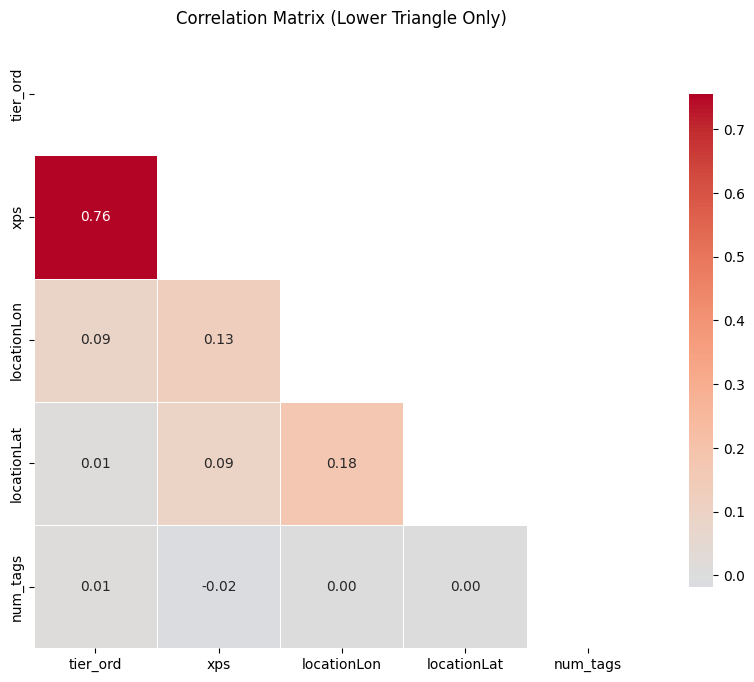

In [44]:
corr_matrix = poi_df_final[['tier_ord','xps','locationLon','locationLat','num_tags']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix (Lower Triangle Only)")
plt.show()

Se observa que las variables 'tier_ord' y 'xps' tienen una correlación de 0.76. Como vamos a pasar el dataset por una red neuronal, no hace falta que se descarte ninguna de las dos variables.

## 2.3. Creación de métrica de engagement:

Las métricas de engagement presentes en el dataset son las siguientes:
- Visits
- Likes y dislikes
- Bookmarks

a continuación se visualizan los datos brevemente:

In [45]:
poi_metrics = poi_df_final[["Visits", "Likes", "Dislikes", "Bookmarks"]]
poi_df_final = poi_df_final.drop(["Visits", "Likes", "Dislikes", "Bookmarks"], axis = 1)

array([[<Axes: title={'center': 'Visits'}>,
        <Axes: title={'center': 'Likes'}>],
       [<Axes: title={'center': 'Dislikes'}>,
        <Axes: title={'center': 'Bookmarks'}>]], dtype=object)

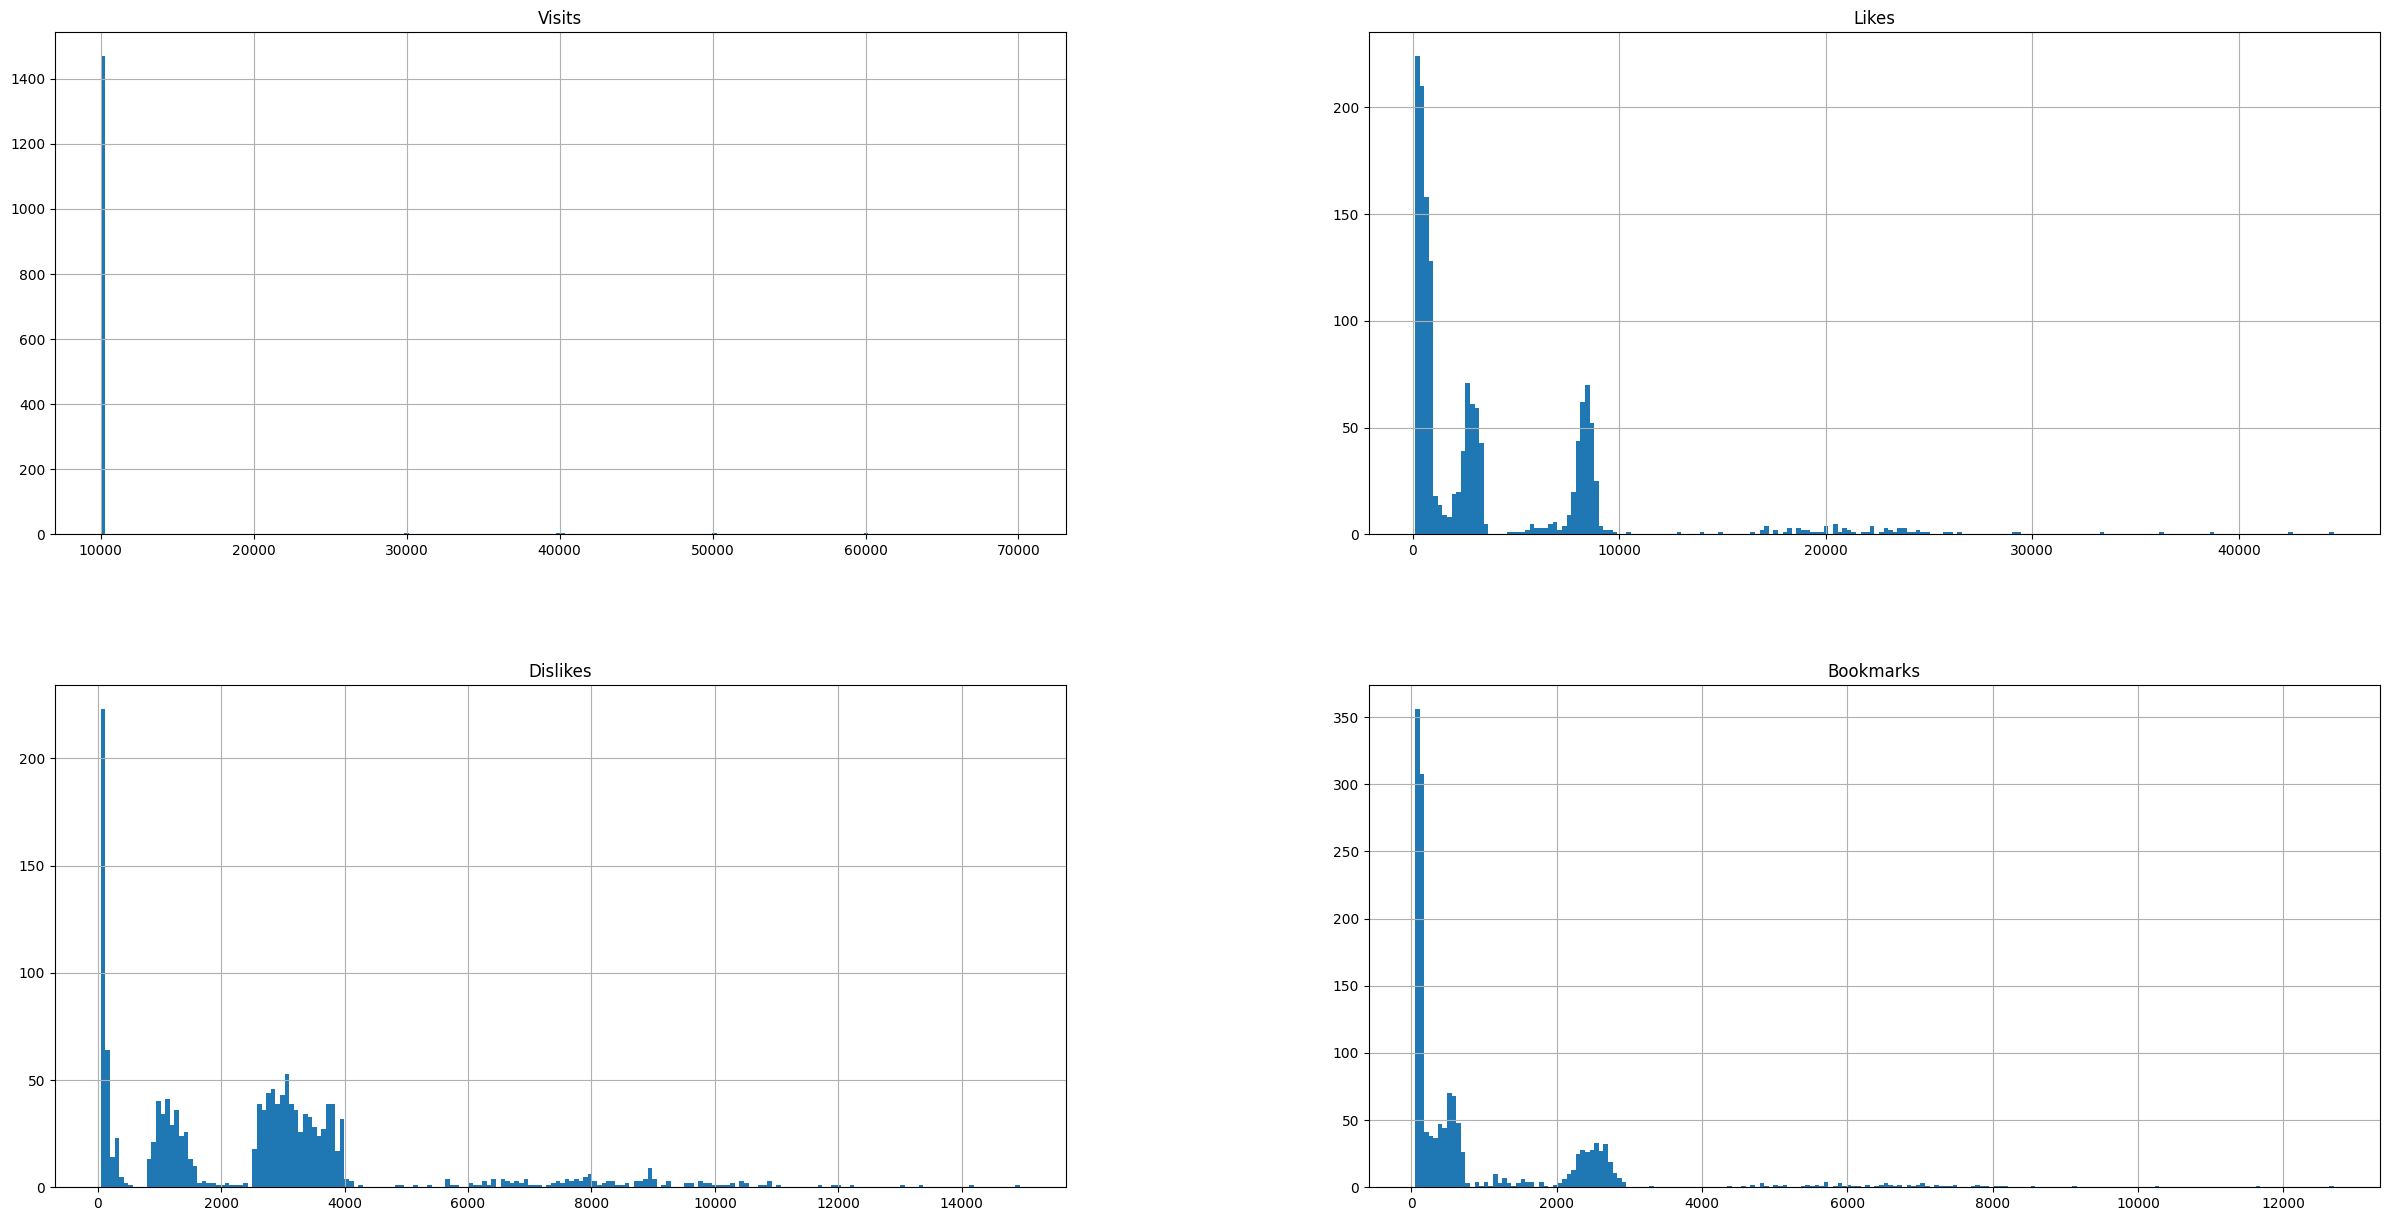

In [46]:
poi_metrics[["Visits", "Likes", "Dislikes", "Bookmarks"]].hist(bins=200, figsize=(30, 15))

Como se puede observar, la distribucion de todos estos datos esta bastante sesgada hacia la izquierda. Para intentar resolver este problema, se van a crear tres variables nuevas:
- Likes_rate = Likes / Visits
- Dislikes_rate = Dislikes / Visits
- Bookmarks_rate = Bookmarks / Visits

incluimos 'e' en estas ecuaciones para asegurar que no se está dividiendo entre 0.

In [47]:
eps = 1e-6

array([[<Axes: title={'center': 'Likes_rate'}>,
        <Axes: title={'center': 'Dislikes_rate'}>],
       [<Axes: title={'center': 'Bookmarks_rate'}>, <Axes: >]],
      dtype=object)

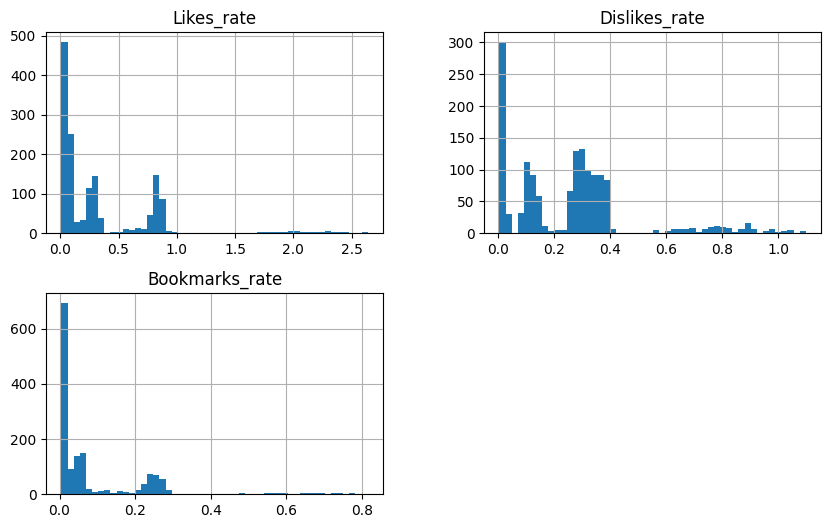

In [48]:
# Se crean las variables propuestas, y se visualizan mediante histogramas:
poi_metrics["Likes_rate"] = (poi_metrics["Likes"]/(poi_metrics["Visits"]+ eps))
poi_metrics["Dislikes_rate"] = (poi_metrics["Dislikes"]/(poi_metrics["Visits"]+ eps))
poi_metrics["Bookmarks_rate"] = (poi_metrics["Bookmarks"]/(poi_metrics["Visits"]+ eps))
poi_metrics[["Likes_rate", "Dislikes_rate", "Bookmarks_rate"]].hist(bins=50, figsize=(10, 6))


Las distribuciones siguen estando sesgadas. No obstante, se van a unificar todas estas features en una única métrica:

- Se va a tener más en cuenta los bookmarks que los likes/dislikes, ya que se considera que un usuario guarde el POI es más indicativo de que le ha interesado el POI que si sólo le da un like.

- Por tanto, la ecuación usada es la siguiente:

engagement_metric = (likes/(visits + e)) - (dislikes/(visits + e)) + 2*(bookmarks/(visits + e))

In [49]:
engagement_metric = poi_metrics[["Likes_rate","Dislikes_rate","Bookmarks_rate"]]

In [50]:
engagement_metric["Engagement_metric"] = (
    poi_metrics["Likes_rate"]
  - poi_metrics["Dislikes_rate"]
  + 2*poi_metrics["Bookmarks_rate"]
)

/tmp/ipython-input-432675884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engagement_metric["Engagement_metric"] = (


<Axes: >

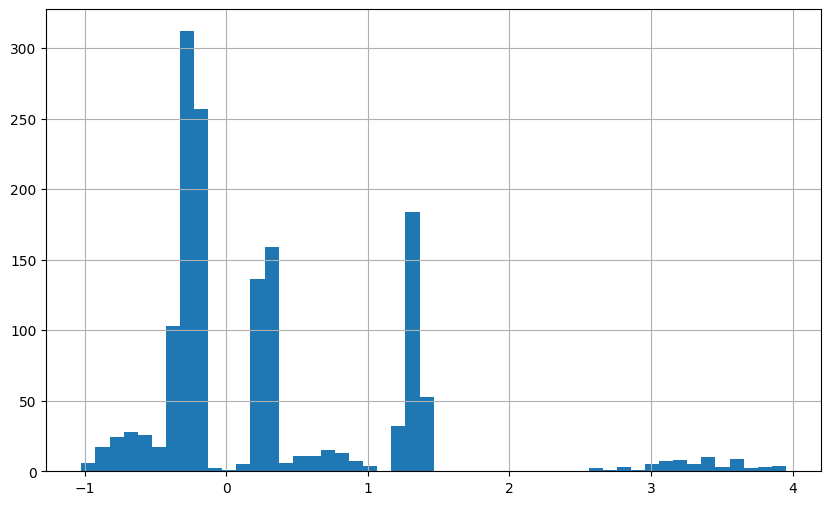

In [51]:
engagement_metric["Engagement_metric"].hist(bins=50, figsize=(10, 6))

In [52]:
engagement_metric["Engagement_metric"].value_counts()

,count
Engagement_metric,
-0.198981,2
-0.175524,2
-0.281106,2
-0.263951,2
1.407156,1
...,...
0.281931,1
3.067632,1
-0.872791,1


In [53]:
y =engagement_metric[["Engagement_metric"]]

In [54]:
y.head()

,Engagement_metric
0,-0.199600
1,1.278394
2,1.250750
3,1.322574
4,-0.338062


## 2.4. División estratificada del dataset:

In [55]:
engagement_metric["Engagement_metric"].shape

(1492,)

In [56]:
X_meta = poi_df_final[["xps","tier_ord","num_tags","locationLon","locationLat","categories_idx","main_image_path"]]
X_meta.head()

,xps,tier_ord,num_tags,locationLon,locationLat,categories_idx,main_image_path
0,1000,1.000000,0,-5.776669,40.111279,"[4, 11]",data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7...
1,250,0.666667,0,-3.714472,40.410457,"[10, 6]",data_main/005fe23a-7f9e-4a57-a24a-1e9a6f1c1702...
2,800,1.000000,0,-3.711620,40.406714,"[1, 10]",data_main/00761a42-1b02-42f3-b2b2-211ffd985118...
3,150,0.333333,0,-3.714567,40.412984,[3],data_main/0089bb20-c132-496c-b215-1986fcfa9d4b...
4,600,0.666667,0,-3.652625,40.450756,"[10, 3]",data_main/00f483bf-a5a2-4009-bc67-b9f3f2e73488...


A continuación, se procede a stratificar los datos.

In [57]:
# Para targets continuos, se crean bins para la stratificacion
n_bins = 5
y_bins = pd.qcut(y["Engagement_metric"], q=n_bins, labels=False, duplicates='drop')

In [58]:
# A continuación, llevamos a cabo los splits
# Primer split: train vs temp (val + test)
X_train_meta, X_temp_meta, y_train, y_temp, y_bins_train, y_bins_temp = train_test_split(
    X_meta,
    y,
    y_bins,
    test_size=0.3,
    random_state=42,
    stratify=y_bins
)

# Segundo split: temp → validation & test
X_val_meta, X_test_meta, y_val, y_test = train_test_split(
    X_temp_meta,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_bins_temp
)

In [59]:
y_train = y_train['Engagement_metric']
y_val   = y_val['Engagement_metric']
y_test  = y_test['Engagement_metric']

In [60]:
# Se traducen las coordenadas de latitud y longitud a coordenadas  esféricas
# (se crea una función para así poder transformar estas variables de forma
# independiente en cada split).

def add_spherical_coords(df, lat_col='locationLat', lon_col='locationLon'):
    lat = np.deg2rad(df[lat_col].values)
    lon = np.deg2rad(df[lon_col].values)

    df = df.copy() # Por seguridad
    df['x'] = np.cos(lat) * np.cos(lon)
    df['y'] = np.cos(lat) * np.sin(lon)
    df['z'] = np.sin(lat)
    return df

In [61]:
# Se aplica la función anterior en los 3 splits
X_train_meta = add_spherical_coords(X_train_meta)
X_val_meta   = add_spherical_coords(X_val_meta)
X_test_meta  = add_spherical_coords(X_test_meta)

In [62]:
# Se normalizan las variables numéricas (cada split por separado)

num_features = ['xps', 'tier_ord', 'num_tags', 'x', 'y', 'z']

scaler = StandardScaler()
scaler.fit(X_train_meta[num_features])

X_train_meta[num_features] = scaler.transform(X_train_meta[num_features])
X_val_meta[num_features] = scaler.transform(X_val_meta[num_features])
X_test_meta[num_features] = scaler.transform(X_test_meta[num_features])

In [63]:
# Se normaliza el target (añadido tras primer entrenamiento)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

In [64]:
# Se alinean los splits de las imágenes con los splits de metadatos, a traves de la variable "main_image_path"
train_image_paths = X_train_meta['main_image_path'].values
val_image_paths   = X_val_meta['main_image_path'].values
test_image_paths  = X_test_meta['main_image_path'].values

In [65]:
# Sanity check para asegurar que las longitudes de los splits de train, val y test
# de las imagenes, metadatos y targets.
assert len(X_train_meta) == len(y_train) == len(train_image_paths)
assert len(X_val_meta)   == len(y_val)   == len(val_image_paths)
assert len(X_test_meta)  == len(y_test)  == len(test_image_paths)

In [66]:
# Se verifica la distribución por bins usando pd.qcut
y_bins_train, bin_edges = pd.qcut(
    y_train,
    q=n_bins,
    labels=False,
    retbins=True,
    duplicates='drop'
)
y_bins_val = pd.cut(
    y_val,
    bins=bin_edges,
    labels=False,
    include_lowest=True
)

y_bins_test = pd.cut(
    y_test,
    bins=bin_edges,
    labels=False,
    include_lowest=True
)


In [67]:
print("Train bins:", np.bincount(y_bins_train))
print("Val bins:", np.bincount(y_bins_val.dropna().astype(int)))
print("Test bins:", np.bincount(y_bins_test.dropna().astype(int)))

Train bins: [209 209 208 209 209]
Val bins: [45 44 45 45 44]
Test bins: [45 45 43 46 43]


In [68]:
# Asegurar el alineamiento de los metadatos y las imagenes
for i in range(5):
    print(
        X_train_meta.iloc[i]['main_image_path'],
          y_train.iloc[i]
        )

data_main/b608b232-5447-4251-85fa-1216596bf31b/main.jpg 0.3299690216518467
data_main/07ee926e-f872-4ded-90bf-4214f3072949/main.jpg -0.282689042025503
data_main/3f45df27-489c-4ed8-8c05-47c5fad1a959/main.jpg -0.24967555153741883
data_main/cad1e8ea-b86d-4f2d-af79-95525f2a0a02/main.jpg -0.15370018973797064
data_main/56d8137c-6bca-4010-ab6f-cc0c06f7d9cc/main.jpg -0.33789452653436924


In [69]:
X_train_meta['categories_idx'].dtype

dtype('O')

In [70]:
X_train_meta['categories_idx'].head(5)

,categories_idx
1050,"[3, 0, 6]"
45,[4]
375,"[10, 0, 6]"
1153,"[10, 9, 1]"
518,"[4, 6, 3]"


## 2.5. (Optional) Data Augmentation:


In [71]:
train_img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),

    # Data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0)
    ),

    transforms.ToTensor(),

    # Imagenet stats (si usas backbone pretrained)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [72]:
class POIDataset(Dataset):
  # Se define la función del dataset a usar (con sus tres partes,image (las imagenes),
  # meta (metadatos), y target (las engagement metrics)

    def __init__(self, meta_df, y, img_root, img_transform=None):
        self.meta_df = meta_df.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.img_root = img_root
        self.img_transform = img_transform

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self, idx):

      # Imágenes
      rel_path = self.meta_df.loc[idx, 'main_image_path']
      img_path = os.path.join(self.img_root, rel_path)

      image = Image.open(img_path).convert("RGB")
      if self.img_transform:
          image = self.img_transform(image)

      # Metadata (numéricos)
      meta_num = torch.tensor(
          self.meta_df.loc[idx, ['xps','tier_ord','num_tags','x','y','z']]
              .values.astype(np.float32),
          dtype=torch.float32
      )

      # Metadata (categorías multi´label)
      cat_list = self.meta_df.loc[idx, 'categories_idx']
      cat_tensor = torch.tensor(cat_list, dtype=torch.long)

      # Target
      target = torch.tensor(self.y.iloc[idx], dtype=torch.float32)

      return image, meta_num, cat_tensor, target

In [73]:
# Convertir numpy arrays de vuelta a pandas Series
# MODIFICADO TRAS PRIMER ENTRENAMIENTO
y_train_series = pd.Series(y_train_scaled, index=X_train_meta.index)
y_val_series = pd.Series(y_val_scaled, index=X_val_meta.index)
y_test_series = pd.Series(y_test_scaled, index=X_test_meta.index)

train_dataset = POIDataset(
    meta_df=X_train_meta,
    y= y_train_series,
    img_root=IMAGE_ROOT,
    img_transform=train_img_transforms
)

val_dataset = POIDataset(
    meta_df=X_val_meta,
    y=y_val_series,
    img_root=IMAGE_ROOT,
    img_transform=eval_img_transforms
)

test_dataset = POIDataset(
    meta_df=X_test_meta,
    y=y_test_series,
    img_root=IMAGE_ROOT,
    img_transform=eval_img_transforms
)

In [74]:
def collate_fn(batch):
# Se define una función que desempaqueta el batch por columnas y
# 'apila' las imágenes,los metadatos numericos y los categoricos, calcula el offset
# y devolver todo esto en forma de tensores
    images, meta, cats, targets = zip(*batch)

    images = torch.stack(images)
    meta = torch.stack(meta)
    targets = torch.stack(targets)

    flat_cats = []
    offsets = []
    offset = 0

    for c in cats:
        offsets.append(offset)
        flat_cats.extend(c.tolist())
        offset += len(c)

    flat_cats = torch.tensor(flat_cats, dtype=torch.long)
    offsets = torch.tensor(offsets, dtype=torch.long)

    return images, meta, flat_cats, offsets, targets

def seed_worker(worker_id):
# Esta función define el see a usar en el dataloader, para asegurar
# la reproducibilidad.
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [75]:
# Sanity check para asegurar el correcto cargado de los dataloaders
batch = next(iter(train_loader))

images, meta, flat_cats, offsets, targets = batch

print(images.shape)      # debería dar algo tipo [batch, canales RBG,224,224]
print(meta.shape)        # [batch, 6]
print(flat_cats.shape)   # [numero total flattened]
print(offsets.shape)     # [batch]
print(targets.shape)     # [batch]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 3, 224, 224])
torch.Size([32, 6])
torch.Size([99])
torch.Size([32])
torch.Size([32])


como se puede comprobar, el sanity check

# 3. Arquitectura del modelo:

Se va a intentar crear un modelo Late Fusion, que va a consistir de tres partes:

- Imagenes ──► CNN ──img_embedding
                                               
- Metadatos (numericos) ─► MLP ─► meta_embedding
                                                
- Categorias ─► EmbeddingBag

Estas tres ramas luego se fusionan en un punto:
Fusion MLP ─► ŷ

Se va a describir brevemente cada parte del modelo a continuación:

**Rama de Imágenes- CNN:**

No se va a entrenar una CNN desde cero, si no que se va a trabajar con una CNN pre entrenada (en este caso, ResNet), que aprende de patrones visuales y extrae características visuales, además de tener la peculiaridad de la habilidad de oder saltarse capas, que ayuda eliminar el problema del gradiente desvaneciente.

**Rama de metadata numérico:**

En este caso vamos a utilizar una red neuronal MLP (de perceptrones multi-capa).
Esta red neuronal se compone de al menos tres capas con neuronas fully-connected, y utiliza funciones de activación no lineales (en este caso, se optará por ReLU). Como el dataset es pequeño, se optará por aplicar un una arquitectura simple, de pocas capas, y aplicar early stopping y dropout para evitar el overfitting.

**Rama de categorías (EmbeddingBag):**

Se va a utilizar una capa de EmbeddingBag, que  combina la búsqueda del embedding con una reducción (suma, promedio o máximo) en un solo paso, algo que no puede hacer una capa de Embedding estándar.


## 3.1. Desarrollo de un modelo funcional:

**Rama CNN (ResNet):**



In [76]:

# CNN ResNet, modificado después de primer
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()

        backbone = models.resnet18(pretrained=True)

        # Se mantienen congeladas las primeras capas (conv1, bn1, layer1, layer2)
        for param in backbone.parameters():
            param.requires_grad = False

        # Se descongelan las siguientes capas: layer3, layer4 para fine-tuning
        for param in backbone.layer3.parameters():
            param.requires_grad = True
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        self.feature_extractor = nn.Sequential(
            *list(backbone.children())[:-1]  # quitamos la capa fc
        )

        self.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        # se define el forward pass
        x = self.feature_extractor(x)   # [batch, 512, 1, 1]
        x = x.view(x.size(0), -1)       # [batch, 512]
        return self.fc(x)

**Rama MLP:**

In [77]:
class MetaEncoder(nn.Module):
    def __init__(self, input_dim=6, output_dim=64):
        super().__init__()

        # Se van a usar capas ocultas de 32 neuronas para evitar overfitting en datasets pequeños
        # Se añade Dropout (0.4) para mejorar la generalización
        # aumentado dropout tras primer entrenamiento
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),  # Estabiliza y acelera el entrenamiento normalizando las activaciones.
            nn.Dropout(0.4),     # Diseñado para evitar el overfitting,
                                 # forzando a la red a aprender representaciones redundantes.

            nn.Linear(32, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

**Rama de categorías:**

In [78]:
class CategoryEncoder(nn.Module):
  # Crea un vector con el numero de categorias presentes en cada entrada del dataset
  # y usa el promedio para agregarlos. Este vector mantiene la informacion semántica
  # de las categorias.

    def __init__(self, num_categories, emb_dim=32):
        super().__init__()

        self.embedding = nn.EmbeddingBag(
            num_embeddings=num_categories,
            embedding_dim=emb_dim,
            mode="mean"
        )

    def forward(self, flat_cats, offsets):
        return self.embedding(flat_cats, offsets)

A continuacion se pasa a la fusion de las ramas. se concatena cada rama:

 img + meta + cat:  (256 + 64 + 32 = 352)

In [79]:
# MODIFICADO TRAS PRIMER ENTRENAMIENTO
class FusionRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  #  dos veces mas de neuronas
            nn.BatchNorm1d(256),         # aplicacion de Batchnorm y Dropout en
            nn.ReLU(),                   # las capas de fusión
            nn.Dropout(0.5),             #  aumento de 0.3 a 0.5

            nn.Linear(256, 128),          # inclusion de una capa más
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

A continuación se define la clase del modelo global:

In [80]:
class LateFusionModel(nn.Module):
    def __init__(self, num_categories):
        super().__init__()
    # Las diferentes ramas del modelo
        self.img_enc = ImageEncoder(256)
        self.meta_enc = MetaEncoder(6, 64)
        self.cat_enc = CategoryEncoder(num_categories, 32)
    # La capa de fusión
        self.regressor = FusionRegressor(256 + 64 + 32)

    def forward(self, images, meta, flat_cats, offsets):
        img_feat = self.img_enc(images)
        meta_feat = self.meta_enc(meta)
        cat_feat = self.cat_enc(flat_cats, offsets)

        fused = torch.cat([img_feat, meta_feat, cat_feat], dim=1)

        return self.regressor(fused)

Sanity check de 'shape' para asegurarnos que es seguro entrenar:

In [81]:
batch = next(iter(train_loader))
images, meta, flat_cats, offsets, y = batch

model = LateFusionModel(num_categories=12)

y_hat = model(images, meta, flat_cats, offsets)

print(y_hat.shape)  # [B]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 346MB/s]


torch.Size([32])


## 3.2. Justificación detallada de decisiones arquitectónicas:

**Rama CNN (ResNet):**
En esta rama se escoje trabajar con una red convulcional preentrenada por tener esta ventajas sobre una CNN sin pre entrenamiento. A continuación explico algunas de estas ventajas:

- ResNet viene con pesos optimizados preentrenados con un altisimo volumen de imagenes de ImageNet.
- Es más indicado para datasets pequeños (como es el caso de este dataset, que solo consiste de 1500 entradas).
- El tiempo de entrenamiento es menor que en un CNN sin entrenar (este modelo puede llegar a tener un buen nivel de precisión a los 5-10 epochs, mientras que un modelo no entrenado puede tardar al rededor de los 100 epochs en conseguir los mismos niveles.
- En conjunto con el dropout que se implementamos en otras capas, una red pre entrenada es menos propensa a memorizar el ruido de nuestras imágenes.
- Tiene también menor riesgo de overfitting, y una precisión final en principio superior a una CNN sin entrenar.


**Rama MLP**
Se ha decidido optar por una MLP bastante pequeña y simple debido al tamaño pequeño del dataset. Por tanto, se ha optado por una profundidad de 2 capas (1 capa oculta de 32 neuronas y una capa de salida, de 64.

Se opta por realizar un par de acciones sobre la capa intermedia:

- BatchNorm1d:  Toma las salidas de las 32 neuronas y las re-escala para que tengan una media de 0 y una desviación estándar de 1 (hace la función de estabilizador). Al normalizar los datos, los pesos de la red convergen mucho más rápido.Además, la red se vuelve menos sensible a cambios bruscos, y
mantiene los valores en un rango donde la función ReLU de PyTorch sigue siendo efectiva.

- Dropout: Se encarga de evitar que tu red de 1500 filas se vuelva "perezosa" y memorice el dataset (evita el overfitting).

**Category Embedder:**
Se usa EmbeddingBag porque realiza reducción y embedding en una operación, es más fiable con datasets pequeños, hace uso de los offsets y asi evita el uso de padding, puede aprender de relaciones semánticas, que para esta variable es aconsejable.

# 4. Entrenamiento y Optimización:

## 4.1. Implementación del pipeline de entrenamiento:

In [82]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Inicializar el modelo
model = LateFusionModel(num_categories=12).to(device)

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

# Scheduler de learning rate - reduce el LR cuando val loss se estanque
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Configuración del early stop
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

early_stopping = EarlyStopping(patience=7, min_delta=0.001)

print("Pipeline de entrenamiento configurado correctamente.")

Usando dispositivo: cpu
Pipeline de entrenamiento configurado correctamente.


## 4.2. Entrenamiento efectivo del modelo:

In [83]:
# Función de entrenamiento
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, meta, flat_cats, offsets, y in tqdm(loader, desc="Training"):
        # Mover datos al dispositivo
        images = images.to(device)
        meta = meta.to(device)
        flat_cats = flat_cats.to(device)
        offsets = offsets.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(images, meta, flat_cats, offsets)
        loss = criterion(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        #clip_grad_norm añadido después del primer entrenamiento
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Función de validación
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, meta, flat_cats, offsets, y in tqdm(loader, desc="Validation"):
            # Mover datos al dispositivo
            images = images.to(device)
            meta = meta.to(device)
            flat_cats = flat_cats.to(device)
            offsets = offsets.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(images, meta, flat_cats, offsets)
            loss = criterion(y_pred, y)

            total_loss += loss.item()
            all_preds.extend(y_pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds), np.array(all_targets)

## 4.3. Documentación del proceso experimental:

In [84]:
# Loop principal de entrenamiento
num_epochs = 30
train_losses = []
val_losses = []
learning_rates = []

print("Iniciando entrenamiento...\n")

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*60}")

    # Entrenar
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validar
    val_loss, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # Calcular métricas adicionales
    mae = np.mean(np.abs(val_preds - val_targets))
    rmse = np.sqrt(val_loss)

    # Calcular R²
    ss_res = np.sum((val_targets - val_preds) ** 2)
    ss_tot = np.sum((val_targets - np.mean(val_targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Guardar learning rate actual
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Imprimir resultados
    print(f"\nResultados del Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val MAE:    {mae:.4f}")
    print(f"  Val RMSE:   {rmse:.4f}")
    print(f"  Val R²:     {r2:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")

    # Actualizar learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n⚠️  Early stopping activado!")
        print(f"Mejor validación loss: {early_stopping.best_loss:.4f}")
        # Restaurar el mejor modelo
        model.load_state_dict(early_stopping.best_model)
        break

print("\n" + "="*60)
print("Entrenamiento completado!")
print("="*60)

# Guardar el modelo final
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, '/content/drive/MyDrive/practicas_DL/late_fusion_model.pth')

print("\n✅ Modelo guardado exitosamente.")

Iniciando entrenamiento...


Epoch 1/30


Validation: 100%|██████████| 7/7 [00:49<00:00,  7.00s/it]



Resultados del Epoch 1:
  Train Loss: 0.9929
  Val Loss:   0.8778
  Val MAE:    0.6140
  Val RMSE:   0.9369
  Val R²:     0.1448
  Learning Rate: 0.000500

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:16<00:00,  2.29s/it]



Resultados del Epoch 2:
  Train Loss: 0.7955
  Val Loss:   0.5030
  Val MAE:    0.4813
  Val RMSE:   0.7092
  Val R²:     0.5100
  Learning Rate: 0.000500

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]



Resultados del Epoch 3:
  Train Loss: 0.7566
  Val Loss:   0.8341
  Val MAE:    0.5724
  Val RMSE:   0.9133
  Val R²:     0.1873
  Learning Rate: 0.000500
EarlyStopping counter: 1 out of 7

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it]



Resultados del Epoch 4:
  Train Loss: 0.6044
  Val Loss:   0.4512
  Val MAE:    0.4445
  Val RMSE:   0.6717
  Val R²:     0.5604
  Learning Rate: 0.000500

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]



Resultados del Epoch 5:
  Train Loss: 0.6097
  Val Loss:   0.5654
  Val MAE:    0.4805
  Val RMSE:   0.7519
  Val R²:     0.4492
  Learning Rate: 0.000500
EarlyStopping counter: 1 out of 7

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]



Resultados del Epoch 6:
  Train Loss: 0.5174
  Val Loss:   0.5000
  Val MAE:    0.4276
  Val RMSE:   0.7071
  Val R²:     0.5128
  Learning Rate: 0.000500
EarlyStopping counter: 2 out of 7

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]



Resultados del Epoch 7:
  Train Loss: 0.5129
  Val Loss:   0.8612
  Val MAE:    0.5318
  Val RMSE:   0.9280
  Val R²:     0.1609
  Learning Rate: 0.000500
EarlyStopping counter: 3 out of 7

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:17<00:00,  2.55s/it]



Resultados del Epoch 8:
  Train Loss: 0.5046
  Val Loss:   0.6687
  Val MAE:    0.5034
  Val RMSE:   0.8178
  Val R²:     0.3485
  Learning Rate: 0.000500
EarlyStopping counter: 4 out of 7

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]



Resultados del Epoch 9:
  Train Loss: 0.4598
  Val Loss:   0.4640
  Val MAE:    0.4206
  Val RMSE:   0.6811
  Val R²:     0.5480
  Learning Rate: 0.000250
EarlyStopping counter: 5 out of 7

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]



Resultados del Epoch 10:
  Train Loss: 0.4036
  Val Loss:   0.3982
  Val MAE:    0.4076
  Val RMSE:   0.6310
  Val R²:     0.6120
  Learning Rate: 0.000250

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it]



Resultados del Epoch 11:
  Train Loss: 0.3536
  Val Loss:   0.4612
  Val MAE:    0.4174
  Val RMSE:   0.6791
  Val R²:     0.5507
  Learning Rate: 0.000250
EarlyStopping counter: 1 out of 7

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]



Resultados del Epoch 12:
  Train Loss: 0.3689
  Val Loss:   0.5028
  Val MAE:    0.4293
  Val RMSE:   0.7091
  Val R²:     0.5101
  Learning Rate: 0.000250
EarlyStopping counter: 2 out of 7

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.26s/it]



Resultados del Epoch 13:
  Train Loss: 0.3194
  Val Loss:   0.5867
  Val MAE:    0.4371
  Val RMSE:   0.7660
  Val R²:     0.4284
  Learning Rate: 0.000250
EarlyStopping counter: 3 out of 7

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it]



Resultados del Epoch 14:
  Train Loss: 0.3260
  Val Loss:   0.4233
  Val MAE:    0.4153
  Val RMSE:   0.6506
  Val R²:     0.5876
  Learning Rate: 0.000250
EarlyStopping counter: 4 out of 7

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it]



Resultados del Epoch 15:
  Train Loss: 0.3111
  Val Loss:   0.4010
  Val MAE:    0.3786
  Val RMSE:   0.6333
  Val R²:     0.6093
  Learning Rate: 0.000125
EarlyStopping counter: 5 out of 7

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]



Resultados del Epoch 16:
  Train Loss: 0.2958
  Val Loss:   0.3994
  Val MAE:    0.3776
  Val RMSE:   0.6320
  Val R²:     0.6109
  Learning Rate: 0.000125
EarlyStopping counter: 6 out of 7

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]



Resultados del Epoch 17:
  Train Loss: 0.2506
  Val Loss:   0.4246
  Val MAE:    0.3866
  Val RMSE:   0.6516
  Val R²:     0.5864
  Learning Rate: 0.000125
EarlyStopping counter: 7 out of 7

⚠️  Early stopping activado!
Mejor validación loss: 0.3982

Entrenamiento completado!

✅ Modelo guardado exitosamente.


## 4.5. Implementación básica de técnicas anti-overfitting:

Estas mejoras se explican en la memoria de las prácticas.

# 5. Evaluación y Análisis:

## 5.1. Evaluación en conjunto de test:

A continuación se prueba el modelo sobre el conjunto test.

In [85]:
def evaluate_test_set(model, test_loader, y_scaler, device):
    # Evalúa el modelo en el conjunto de test.

    model.eval()
    all_preds = []
    all_targets = []

    print("Evaluando en conjunto de test...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test"):
            images, meta, flat_cats, offsets, targets = batch

            # Mover a dispositivo
            images = images.to(device)
            meta = meta.to(device)
            flat_cats = flat_cats.to(device)
            offsets = offsets.to(device)
            targets = targets.to(device)

            # Predicción
            outputs = model(images, meta, flat_cats, offsets)

            # Guardar predicciones y targets (en CPU)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenar todos los batches
    preds_scaled = np.concatenate(all_preds)
    targets_scaled = np.concatenate(all_targets)

    # ⭐ DES-NORMALIZAR para obtener valores en escala original
    preds_original = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    targets_original = y_scaler.inverse_transform(targets_scaled.reshape(-1, 1)).flatten()

    # Calcular métricas en AMBAS escalas
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Métricas en escala NORMALIZADA
    mae_scaled = mean_absolute_error(targets_scaled, preds_scaled)
    rmse_scaled = np.sqrt(mean_squared_error(targets_scaled, preds_scaled))
    r2_scaled = r2_score(targets_scaled, preds_scaled)

    # Métricas en escala ORIGINAL
    mae_original = mean_absolute_error(targets_original, preds_original)
    rmse_original = np.sqrt(mean_squared_error(targets_original, preds_original))
    r2_original = r2_score(targets_original, preds_original)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((targets_original - preds_original) / (targets_original + 1e-8))) * 100

    # Mostrar resultados
    print("\n" + "="*70)
    print("RESULTADOS EN CONJUNTO DE TEST")
    print("="*70)

    print("\n Métricas en escala NORMALIZADA (para comparar con entrenamiento):")
    print(f"  MAE:  {mae_scaled:.4f}")
    print(f"  RMSE: {rmse_scaled:.4f}")
    print(f"  R²:   {r2_scaled:.4f}")

    print("\n Métricas en escala ORIGINAL (interpretables):")
    print(f"  MAE:  {mae_original:.4f}")
    print(f"  RMSE: {rmse_original:.4f}")
    print(f"  R²:   {r2_original:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    print("\n" + "="*70)

    # Retornar todo en un diccionario
    results = {
        'preds_scaled': preds_scaled,
        'targets_scaled': targets_scaled,
        'preds_original': preds_original,
        'targets_original': targets_original,
        'metrics_scaled': {
            'mae': mae_scaled,
            'rmse': rmse_scaled,
            'r2': r2_scaled
        },
        'metrics_original': {
            'mae': mae_original,
            'rmse': rmse_original,
            'r2': r2_original,
            'mape': mape
        }
    }

    return results

In [86]:
def plot_test_results(results):
    # Genera gráficos para analizar los resultados del test.

    preds = results['preds_original']
    targets = results['targets_original']
    r2 = results['metrics_original']['r2']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))


    # Scatter plot de predicciones vs Real

    ax = axes[0, 0]
    ax.scatter(targets, preds, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)

    # Línea de predicción perfecta
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción perfecta')

    ax.set_xlabel('Engagement Real', fontsize=12)
    ax.set_ylabel('Engagement Predicho', fontsize=12)
    ax.set_title(f'Predicciones vs Real (R² = {r2:.4f})', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)


    # Distribución de errores

    ax = axes[0, 1]
    errors = preds - targets

    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Error = 0')
    ax.axvline(x=np.mean(errors), color='g', linestyle='--', linewidth=2,
               label=f'Media = {np.mean(errors):.4f}')

    ax.set_xlabel('Error de Predicción', fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.set_title('Distribución de Errores', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')


    # Residuos vs predicciones

    ax = axes[1, 0]
    ax.scatter(preds, errors, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)

    ax.set_xlabel('Predicciones', fontsize=12)
    ax.set_ylabel('Residuos (Error)', fontsize=12)
    ax.set_title('Residuos vs Predicciones', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)


    # Métricas por percentiles

    ax = axes[1, 1]

    # Dividir en percentiles
    percentiles = [0, 25, 50, 75, 100]
    bins = np.percentile(targets, percentiles)
    bin_labels = ['Q1 (0-25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (75-100%)']

    mae_by_percentile = []
    for i in range(len(bins)-1):
        mask = (targets >= bins[i]) & (targets < bins[i+1])
        if i == len(bins)-2:  # Último bin incluye el máximo
            mask = (targets >= bins[i]) & (targets <= bins[i+1])

        if mask.sum() > 0:
            mae = mean_absolute_error(targets[mask], preds[mask])
            mae_by_percentile.append(mae)
        else:
            mae_by_percentile.append(0)

    ax.bar(bin_labels, mae_by_percentile, edgecolor='black', alpha=0.7)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('Error por Percentil de Engagement', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


    # Tabla de ejemplos

    print("\n EJEMPLOS DE PREDICCIONES:")
    print("="*70)

    # Mejores predicciones
    abs_errors = np.abs(errors)
    best_indices = np.argsort(abs_errors)[:5]

    print("\n 5 MEJORES PREDICCIONES:")
    print(f"{'Real':>10} {'Predicho':>10} {'Error':>10}")
    print("-"*35)
    for idx in best_indices:
        print(f"{targets[idx]:10.4f} {preds[idx]:10.4f} {errors[idx]:10.4f}")

    # Peores predicciones
    worst_indices = np.argsort(abs_errors)[-5:][::-1]

    print("\n 5 PEORES PREDICCIONES:")
    print(f"{'Real':>10} {'Predicho':>10} {'Error':>10}")
    print("-"*35)
    for idx in worst_indices:
        print(f"{targets[idx]:10.4f} {preds[idx]:10.4f} {errors[idx]:10.4f}")

    print("\n" + "="*70)

In [102]:
def analyze_errors_by_features(results, X_test_meta):

    # Analiza los errores de predicción según diferentes características.

    preds = results['preds_original']
    targets = results['targets_original']
    errors = np.abs(preds - targets)

    # Resetear índice para alinear con arrays
    X_test_reset = X_test_meta.reset_index(drop=True)

    print("\n🔍 ANÁLISIS DE ERRORES POR CARACTERÍSTICAS")
    print("="*70)


    # Error por TIER

    print("\n📊 Error Medio Absoluto (MAE) por TIER:")
    print("-"*40)
    for tier in sorted(X_test_reset['tier_ord'].unique()):
        mask = X_test_reset['tier_ord'] == tier
        mae = np.mean(errors[mask])
        count = mask.sum()
        print(f"  Tier_ord {tier}: MAE = {mae:.4f} (n={count})")


    # Error por NÚMERO DE TAGS
    print("\n📊 Error Medio Absoluto (MAE) por NÚMERO DE TAGS:")
    print("-"*40)

    # Agrupar num_tags en rangos
    num_tags = X_test_reset['num_tags']
    tag_ranges = [(0, 3, 'Pocos (0-3)'),
                  (4, 7, 'Medio (4-7)'),
                  (8, 20, 'Muchos (8+)')]

    for min_tags, max_tags, label in tag_ranges:
        mask = (num_tags >= min_tags) & (num_tags <= max_tags)
        if mask.sum() > 0:
            mae = np.mean(errors[mask])
            count = mask.sum()
            print(f"  {label}: MAE = {mae:.4f} (n={count})")


    # Error por CATEGORÍAS
    print("\n📊 Error por CATEGORÍAS más comunes:")
    print("-"*40)

    # Extraer primera categoría de cada POI
    def get_first_category(cat_list):
        if isinstance(cat_list, list) and len(cat_list) > 0:
            return cat_list[0]
        return 'Sin categoría'

    if 'categories' in X_test_reset.columns:
        X_test_reset['first_category'] = X_test_reset['categories'].apply(get_first_category)

        # Top 5 categorías más frecuentes
        top_categories = X_test_reset['first_category'].value_counts().head(5).index

        for cat in top_categories:
            mask = X_test_reset['first_category'] == cat
            mae = np.mean(errors[mask])
            count = mask.sum()
            print(f"  {cat}: MAE = {mae:.4f} (n={count})")


    # VISUALIZACIÓN: Error vs Features

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Error vs Tier
    ax = axes[0]
    tier_groups = X_test_reset.groupby('tier_ord').apply(
        lambda x: np.mean(errors[x.index])
    )
    ax.bar(tier_groups.index, tier_groups.values, edgecolor='black', alpha=0.7)
    ax.set_xlabel('tier_ord', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('Error por tier_ord', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Error vs Número de Tags
    ax = axes[1]
    ax.scatter(X_test_reset['num_tags'], errors, alpha=0.5, s=30)
    ax.set_xlabel('Número de Tags', fontsize=12)
    ax.set_ylabel('Error Absoluto', fontsize=12)
    ax.set_title('Error vs Número de Tags', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Error vs XPS
    ax = axes[2]
    ax.scatter(X_test_reset['xps'], errors, alpha=0.5, s=30)
    ax.set_xlabel('XPS', fontsize=12)
    ax.set_ylabel('Error Absoluto', fontsize=12)
    ax.set_title('Error vs XPS', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [103]:
def compare_splits(train_history, val_history, test_results):

    # Compara métricas entre train, validation y test

    # Obtener mejor época (menor val loss)
    best_epoch = np.argmin(val_history)

    print("\n COMPARACIÓN TRAIN vs VAL vs TEST")
    print("="*70)
    print(f"\nMejor época: {best_epoch + 1}")
    print(f"Train Loss:  {train_history[best_epoch]:.4f}")
    print(f"Val Loss:    {val_history[best_epoch]:.4f}")
    print(f"Test Loss:   (calculado con MSE en escala normalizada)")

    # Calcular test loss con MSE
    test_loss_mse = mean_squared_error(
        test_results['targets_scaled'],
        test_results['preds_scaled']
    )
    print(f"             {test_loss_mse:.4f}")

    print("\n📈 R² en cada conjunto:")
    print(f"  Test R²: {test_results['metrics_original']['r2']:.4f}")

    # Visualizar evolución
    plt.figure(figsize=(12, 5))

    # Loss por época
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_history) + 1)
    plt.plot(epochs, train_history, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_history, 'r-', label='Val Loss', linewidth=2)
    plt.axhline(y=test_loss_mse, color='g', linestyle='--', linewidth=2, label='Test Loss')
    plt.axvline(x=best_epoch + 1, color='gray', linestyle=':', alpha=0.7, label='Best Epoch')

    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Evolución del Loss', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Gap Train-Val
    plt.subplot(1, 2, 2)
    gap = np.array(val_history) - np.array(train_history)
    plt.plot(epochs, gap, 'purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.fill_between(epochs, gap, 0, where=(gap > 0), alpha=0.3, color='red', label='Overfitting')
    plt.fill_between(epochs, gap, 0, where=(gap <= 0), alpha=0.3, color='green', label='Underfitting')

    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Val Loss - Train Loss', fontsize=12)
    plt.title('Gap Train-Val (Overfitting)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [104]:
def save_test_results(results, model, y_scaler, save_dir='test_results'):

    # Guarda resultados del test en archivos.

    import pickle
    import json

    os.makedirs(save_dir, exist_ok=True)

    # Guardar métricas en JSON
    metrics_to_save = {
        'metrics_scaled': results['metrics_scaled'],
        'metrics_original': results['metrics_original']
    }

    with open(f'{save_dir}/test_metrics.json', 'w') as f:
        json.dump(metrics_to_save, f, indent=4)

    print(f" Métricas guardadas en {save_dir}/test_metrics.json")

    # Guardar predicciones en CSV
    predictions_df = pd.DataFrame({
        'target_original': results['targets_original'],
        'prediction_original': results['preds_original'],
        'error': results['preds_original'] - results['targets_original'],
        'abs_error': np.abs(results['preds_original'] - results['targets_original'])
    })

    predictions_df.to_csv(f'{save_dir}/test_predictions.csv', index=False)
    print(f"Predicciones guardadas en {save_dir}/test_predictions.csv")

    # Guardar modelo
    torch.save(model.state_dict(), f'{save_dir}/best_model.pth')
    print(f"Modelo guardado en {save_dir}/best_model.pth")

    # Guardar scaler
    with open(f'{save_dir}/y_scaler.pkl', 'wb') as f:
        pickle.dump(y_scaler, f)

    print(f"Scaler guardado en {save_dir}/y_scaler.pkl")

    print(f"\nTodos los resultados guardados en: {save_dir}/")

🔄 Evaluación manual (sin DataLoader workers)...


Test: 100%|██████████| 224/224 [00:17<00:00, 13.04it/s]



📊 RESULTADOS EN TEST

MAE:  0.4304
RMSE: 0.6997
R²:   0.4265


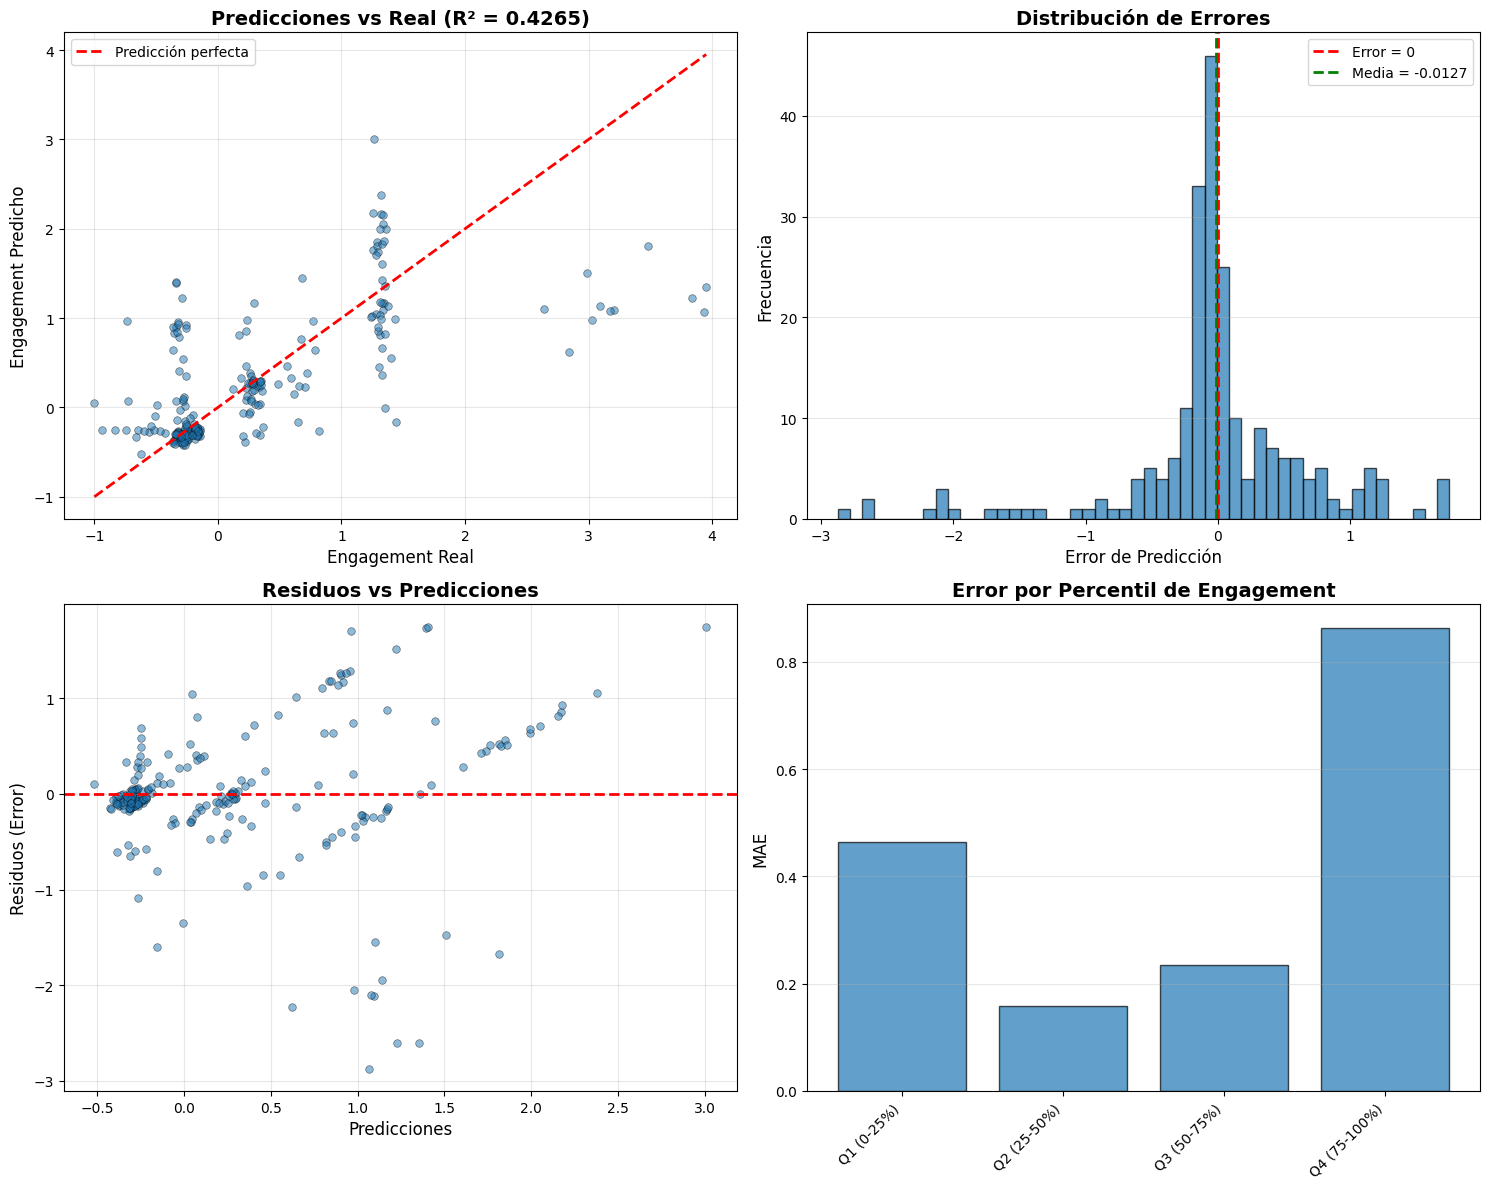


📋 EJEMPLOS DE PREDICCIONES:

✅ 5 MEJORES PREDICCIONES:
      Real   Predicho      Error
-----------------------------------
    0.2776     0.2785     0.0009
    0.2738     0.2710    -0.0028
    1.3548     1.3585     0.0037
   -0.3459    -0.3497    -0.0038
   -0.3043    -0.3102    -0.0059

❌ 5 PEORES PREDICCIONES:
      Real   Predicho      Error
-----------------------------------
    3.9374     1.0641    -2.8733
    3.8352     1.2275    -2.6077
    3.9523     1.3516    -2.6007
    2.8455     0.6237    -2.2219
    3.2025     1.0932    -2.1093


🔍 ANÁLISIS DE ERRORES POR CARACTERÍSTICAS

📊 Error Medio Absoluto (MAE) por TIER:
----------------------------------------
  Tier_ord -3.8192531766310007: MAE = 0.8003 (n=1)
  Tier_ord -2.2451117173326334: MAE = 0.5013 (n=15)
  Tier_ord -0.6709702580342659: MAE = 0.3203 (n=93)
  Tier_ord 0.9031712012641018: MAE = 0.5069 (n=115)

📊 Error Medio Absoluto (MAE) por NÚMERO DE TAGS:
----------------------------------------
  Pocos (0-3): MAE = 0.3942

/tmp/ipython-input-1587322950.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tier_groups = X_test_reset.groupby('tier_ord').apply(


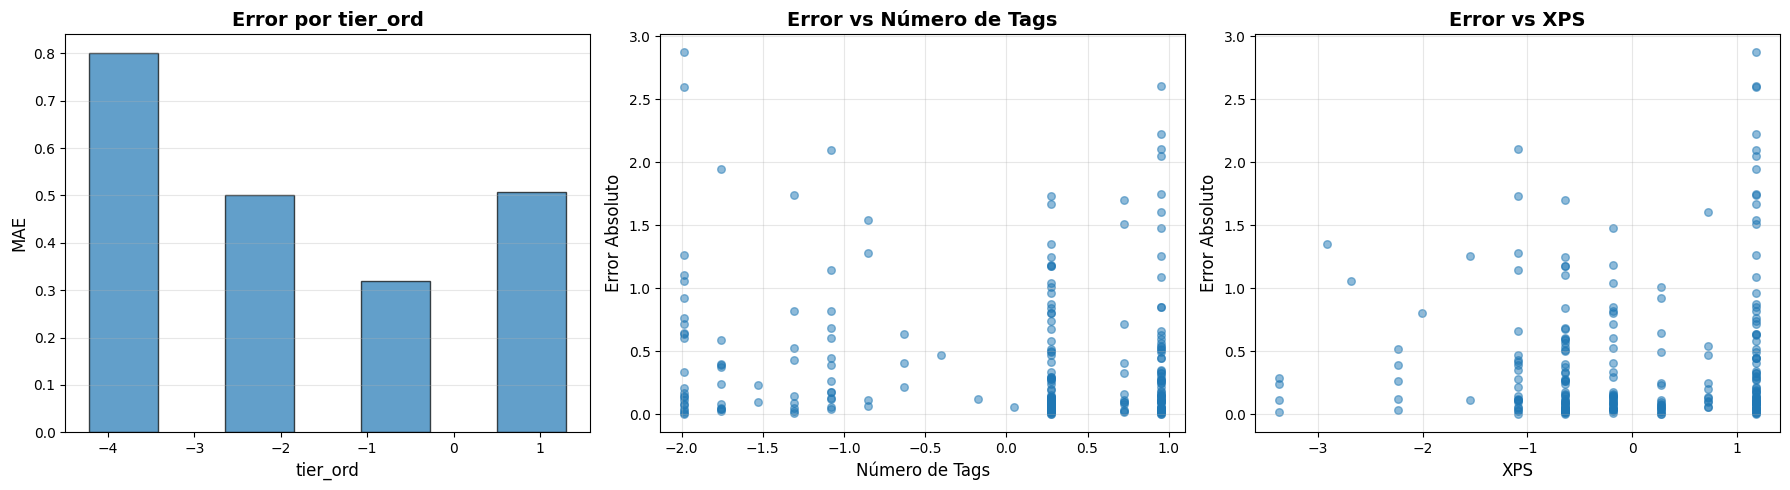

In [106]:

print("Evaluación manual (sin DataLoader workers)...")

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    # Iterar manualmente sobre el dataset
    for i in tqdm(range(len(test_dataset)), desc="Test"):
        img, meta, cats, target = test_dataset[i]

        # Añadir dimensión de batch
        img = img.unsqueeze(0).to(device)
        meta = meta.unsqueeze(0).to(device)
        cats = torch.LongTensor(cats).to(device)
        offsets = torch.LongTensor([0]).to(device)

        # Predicción
        output = model(img, meta, cats, offsets)

        all_preds.append(output.cpu().item())
        all_targets.append(target.item())

# Convertir a arrays
preds_scaled = np.array(all_preds)
targets_scaled = np.array(all_targets)

# Des-normalizar
preds_original = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
targets_original = y_scaler.inverse_transform(targets_scaled.reshape(-1, 1)).flatten()

# Calcular métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(targets_original, preds_original)
rmse = np.sqrt(mean_squared_error(targets_original, preds_original))
r2 = r2_score(targets_original, preds_original)

print("\n" + "="*70)
print("RESULTADOS EN TEST")
print("="*70)
print(f"\nMAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")
print("="*70)

# Guardar en diccionario para usar con las funciones de visualización
test_results = {
    'preds_original': preds_original,
    'targets_original': targets_original,
    'preds_scaled': preds_scaled,
    'targets_scaled': targets_scaled,
    'metrics_original': {'mae': mae, 'rmse': rmse, 'r2': r2},
    'metrics_scaled': {}
}

# Se visualizan los datos
plot_test_results(test_results)
analyze_errors_by_features(test_results, X_test_meta)

## 5.2. Interpretación de resultados:

Realizado en memoria de prácticas